<img width=350 src="https://agentz.ai/wp-content/uploads/2019/11/Agentz-Logo-01-1024x371.png"></img>
<div style="text-align: center; font-size: 18px;"> <h1>Programming assignment for ML developer</h1> </div>


## Background
Let's say we have to develop an AI model that can predict flight delays during the
flight duration based on data about previous delay/turbulence encountered.

## Problem statement
1. What will be the format of data you need to collect?
2. How will you use that to create a model?
3. What training type and algorithm will you select?
4. What are the metrics you will calculate to understand your model's effectiveness?

In [104]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import emoji
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('data/feb-20-flight-delay.csv')

### Data Format
Instead of picking up dataset directly from Kaggle, I preferred to get the data from the website of [US Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236) for the month of February 2020.
After carefully analyzing each data points, I decided to manually pick 9 variable to predict if there will be a delay in the flight.
- __MONTH__ - Month
- __DAY_OF_MONTH__ - Day of Month
- __DAY_OF_WEEK__ - Day of Week
- __OP_UNIQUE_CARRIER__ - Unique Carrier Code
- __ORIGIN__ - Origin airport location
- __DEST__ - Destination airport location
- __DEP_TIME__ - Actual Departure Time (local time: hhmm)
- __DEP_DEL15__ - Departure Delay Indicator, 15 Minutes or More (1=Yes, 0=No) [TARGET VARIABLE]
- __DISTANCE__ - Distance between airports (miles)

In [3]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DISTANCE,Unnamed: 9
0,2,1,6,MQ,CLT,LYH,1430.0,0.0,175.0,NaN
1,2,8,6,MQ,CLT,LYH,1442.0,0.0,175.0,NaN
2,2,13,4,MQ,DFW,SHV,2247.0,0.0,190.0,NaN
3,2,14,5,MQ,DFW,SHV,2230.0,0.0,190.0,NaN
4,2,15,6,MQ,DFW,SHV,2246.0,0.0,190.0,NaN


## Data Preprocessing

We might have an extra column in our dataset, let's get rid of it first

In [4]:
data = data.drop(['Unnamed: 9'], axis=1)

Let's find out the distribution of our target variable

In [5]:
data['DEP_DEL15'].value_counts()

0.0    487135
1.0     82182
Name: DEP_DEL15, dtype: int64

In [6]:
82182/569317 * 100

14.435191641914786

We can see that we have highly imbalanced data, as we there are only __14.43%__ rows with the value of 1.0 (Delay in flight).

We will drop a significant amount of rows where our target variable is 0.0 (No delay in flight).

In [7]:
# Split the data into positive and negative
positive_rows = data.DEP_DEL15 == 1.0
data_pos = data.loc[positive_rows]
data_neg = data.loc[~positive_rows]

# Merge the balanced data
data = pd.concat([data_pos, data_neg.sample(n = len(data_pos))], axis = 0)

# Shuffle the order of data
data = data.sample(n = len(data)).reset_index(drop = True)

Let's quickly remove the NULL values if present any

In [8]:
data.isna().sum()

MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
OP_UNIQUE_CARRIER      0
ORIGIN                 0
DEST                   0
DEP_TIME             831
DEP_DEL15            833
DISTANCE               0
dtype: int64

There are around __~0.5%__ NULL values present in __DEP_TIME__ and __DEP_DEL15__

In [9]:
data = data.dropna(axis=0)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163531 entries, 0 to 164363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              163531 non-null  int64  
 1   DAY_OF_MONTH       163531 non-null  int64  
 2   DAY_OF_WEEK        163531 non-null  int64  
 3   OP_UNIQUE_CARRIER  163531 non-null  object 
 4   ORIGIN             163531 non-null  object 
 5   DEST               163531 non-null  object 
 6   DEP_TIME           163531 non-null  float64
 7   DEP_DEL15          163531 non-null  float64
 8   DISTANCE           163531 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 12.5+ MB


We see that our target variable __DEP_DEL15__ has the datatype of _float64_.

Let's convert it into _int_.

In [11]:
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)

Now let's have a look at the number of columns and rows in our dataset.

In [12]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns in our dataset.")

There are 163531 rows and 9 columns in our dataset.


## Exploratory Data Analysis
Let's uncover some meaningful and hidden insights out of our dataset.

In [13]:
data.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DEL15,DISTANCE
count,163531.0,163531.000000,163531.000000,163531.000000,163531.000000,163531.000000
mean,2.0,14.798760,4.016774,1416.372847,0.502547,792.293376
std,0.0,8.177679,1.918990,498.607218,0.499995,573.463027
min,2.0,1.000000,1.000000,1.000000,0.000000,31.000000
25%,2.0,7.000000,2.000000,1025.000000,0.000000,369.000000
50%,2.0,14.000000,4.000000,1437.000000,1.000000,646.000000
75%,2.0,22.000000,6.000000,1826.000000,1.000000,1034.000000
max,2.0,29.000000,7.000000,2400.000000,1.000000,5095.000000


Apart from the statistics given in the table above, we can also that there are 6 numerical and 3 categorical variables in our dataset.

Let's quickly visualize the distribution of __DISTANCE__ variable

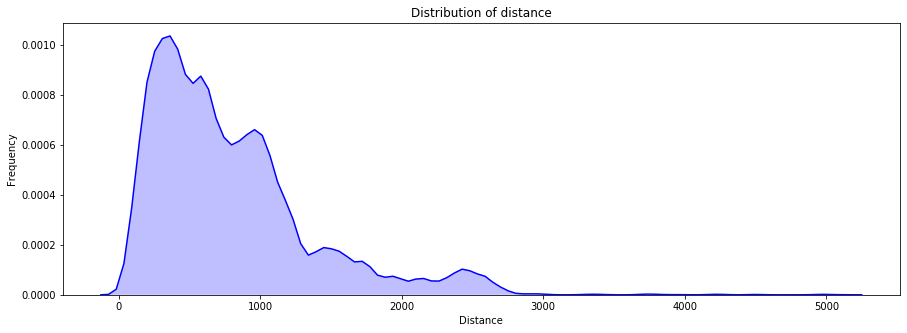

In [14]:
plt.figure(figsize=(15,5))
sns.distplot(data['DISTANCE'], hist=False, color="b", kde_kws={"shade": True})
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of distance")
plt.show()

We can see that our __DISTANCE__ variable is positively skewed.
I am just curious to find out the correlation between the distance and delay of a flight.

In [15]:
print(emoji.emojize("Let's find it out :fire:"))

Let's find it out 🔥


Though, there is no possible way to find correlation between a continuous and categorical variable, I'll try to find the average distance for __DEP_DEL15__ variable.

In [16]:
print(f"Average distance if there is a delay {data[data['DEP_DEL15'] == 1]['DISTANCE'].values.mean()} miles")
print(f"Average distance if there is no delay {data[data['DEP_DEL15'] == 0]['DISTANCE'].values.mean()} miles")

Average distance if there is a delay 786.1071280815751 miles
Average distance if there is no delay 798.5429691821657 miles


Let's visualize the categorical variables.

### Count of carriers in the dataset

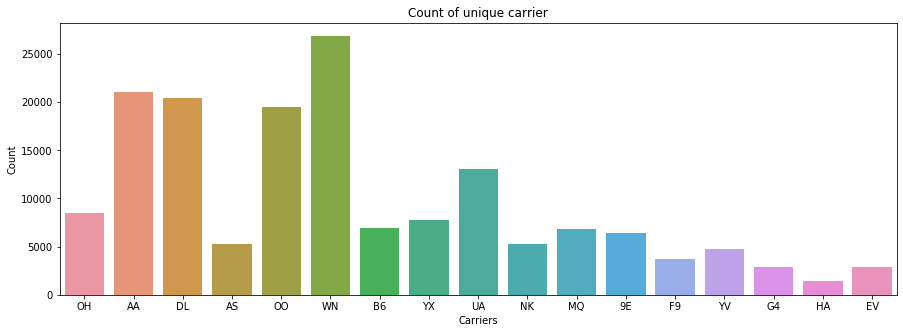

In [17]:
plt.figure(figsize=(15,5))
sns.countplot(x=data['OP_UNIQUE_CARRIER'], data=data)
plt.xlabel("Carriers")
plt.ylabel("Count")
plt.title("Count of unique carrier")
plt.show()

### Count of origin and destination airport

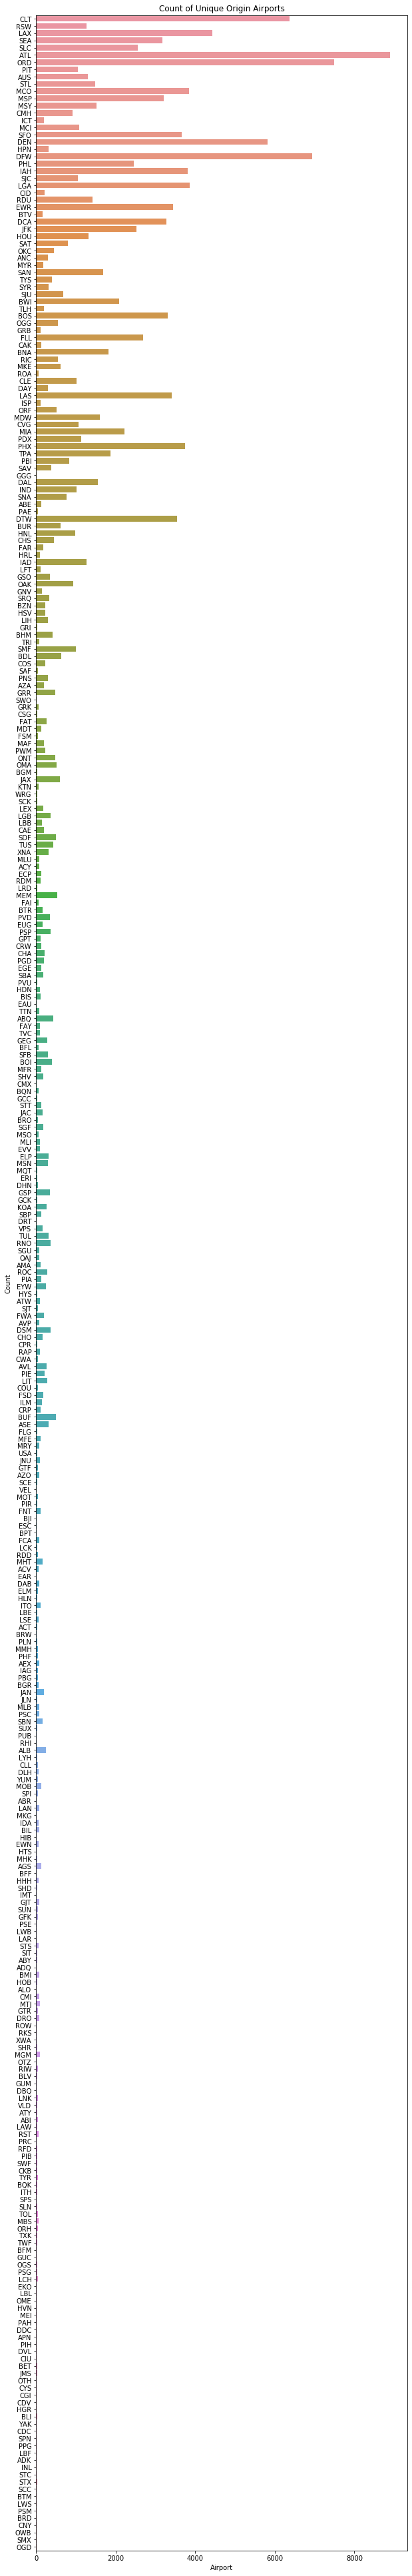

In [18]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['ORIGIN'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Origin Airports")
plt.show()

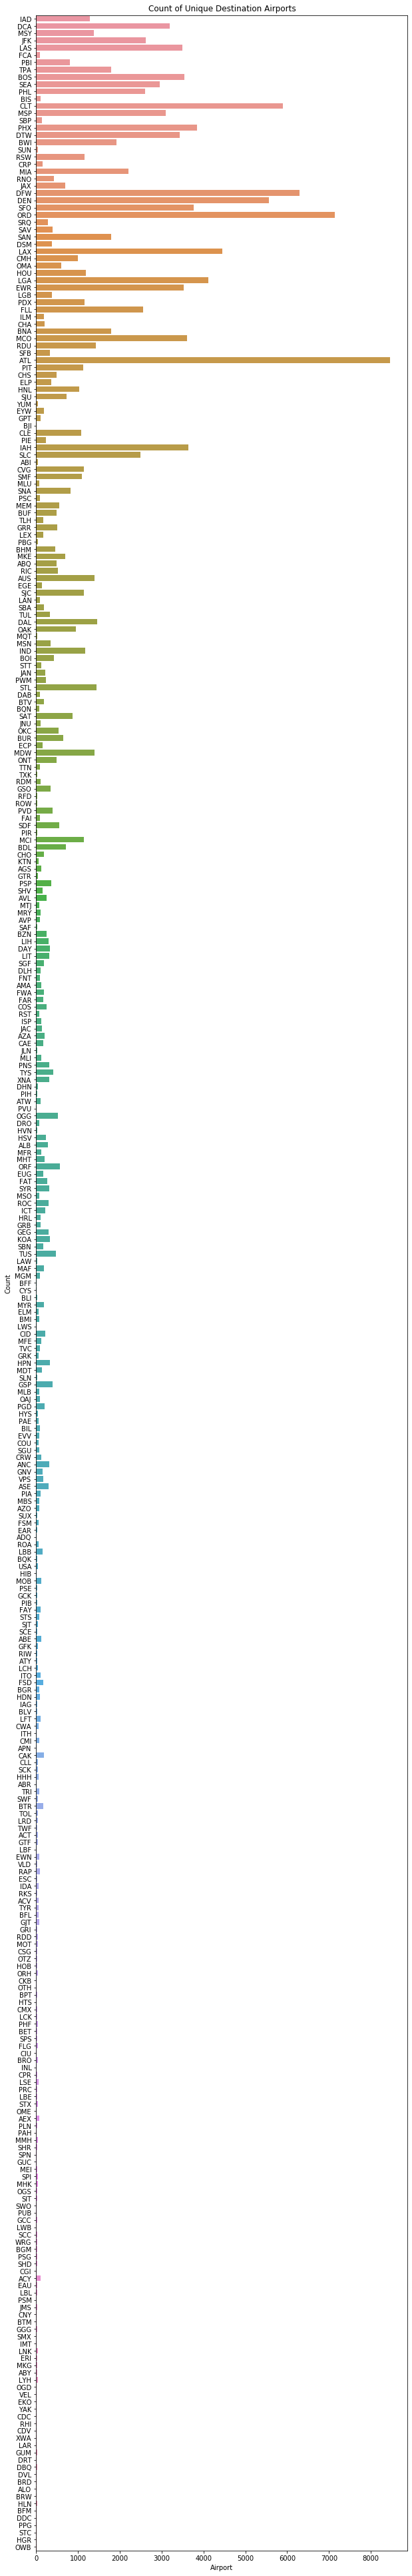

In [19]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['DEST'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Destination Airports")
plt.show()

## Modelling


Our __MONTH__ variable is constant so it will not have any effect on in the training.
It's better to remove it. Also, let's rename the __DEP_DEL15__ column name to __TARGET__ to avoid confusion between predictors and target variable.

In [20]:
data = data.rename(columns={'DEP_DEL15':'TARGET'})

__Encoding the categorical variable__

In [21]:
def label_encoding(categories):
    categories = list(set(list(categories.values)))
    mapping = {}
    for idx in range(len(categories)):
        mapping[categories[idx]] = idx
    return mapping

In [22]:
data['OP_UNIQUE_CARRIER'] = data['OP_UNIQUE_CARRIER'].map(label_encoding(data['OP_UNIQUE_CARRIER']))

In [23]:
data['ORIGIN'] = data['ORIGIN'].map(label_encoding(data['ORIGIN']))

In [24]:
data['DEST'] = data['DEST'].map(label_encoding(data['DEST']))

In [25]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,TARGET,DISTANCE
0,2,20,4,9,88,1,938.0,0,322.0
1,2,27,4,13,159,198,1229.0,0,892.0
2,2,16,7,13,88,248,951.0,1,651.0
3,2,19,3,16,135,80,1228.0,1,2475.0
4,2,27,4,4,225,190,1516.0,1,867.0


In [26]:
data['TARGET'].value_counts()

1    82182
0    81349
Name: TARGET, dtype: int64

In [27]:
X = data[['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME', 'DISTANCE']].values
y = data[['TARGET']].values

In [28]:
# Splitting Train-set and Test-set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=41)

# Splitting Train-set and Validation-set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=41)

### Choosing the evaluation metric
Here we will go with the __Accuracy__ metric for our predicted values because we have already balanced our dataset.
So, accuracy is the best metric to evaluate any binary classification problem if performed on a balanced dataset

In [29]:
# Formula to get accuracy
def get_accuracy(y_true, y_preds):
    # Getting score of confusion matrix
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_preds).ravel()
    # Calculating accuracy
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    return accuracy

### Creating a baseline model

__Logistic Regression__

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

/Users/rowhit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rowhit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


__CatboostClassifier__

In [31]:
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(random_state=0)
catboost.fit(X_train, y_train, verbose=False)

__Naive Bayes__

In [33]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

/Users/rowhit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

__Random Forest Classifier__

In [34]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

/Users/rowhit/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rowhit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

__KNN Classifier__

In [36]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

/Users/rowhit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

__XGBoost Classifier__

In [87]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

/Users/rowhit/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rowhit/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Evaluation of accuracy on validation dataset

In [96]:
models = [lr, catboost, gnb, rf, knn, xgb]
acc = []
for model in models:
    preds_val = model.predict(X_val)
    accuracy = get_accuracy(y_val, preds_val)
    acc.append(accuracy)

In [97]:
model_name = ['Logistic Regression', 'Catboost', 'Naive Bayes', 'Random Forest', 'KNN', 'XGBoost']
accuracy = dict(zip(model_name, acc))

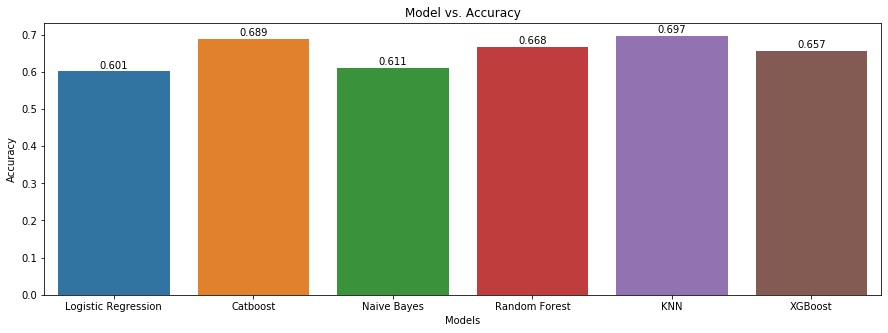

In [98]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x = list(accuracy.keys()), y = list(accuracy.values()))
for p, value in zip(ax.patches, list(accuracy.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()

We tried to fit our data on default parameters of different algorithms for binary classification.

Surprisingly, __KNN Classifier__ turned out to best in terms of validation set accuracy.

### Accuracy on Test set with KNN before hyperparameter tuning

In [99]:
test_preds = knn.predict(X_test)
get_accuracy(y_test, test_preds)

0.6962118200996729

### Hyperparameter tuning for KNN

In [107]:
leaf_size = list(range(1,5))
n_neighbors = list(range(1,3))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn_2 = KNeighborsClassifier()

clf = GridSearchCV(knn_2, hyperparameters, cv=2)

best_model = clf.fit(X_train,y_train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 3
Best p: 1
Best n_neighbors: 1


In [108]:
knn_best = KNeighborsClassifier(leaf_size=3, p=1, n_neighbors=1)

In [114]:
knn_best.fit(X_train, y_train)
test_preds_1 = knn_best.predict(X_test)

### Accuracy on Test set with KNN after hyperparameter tuning

In [115]:
get_accuracy(y_test, test_preds_1)

0.7602959611092427

## Conclusion

#### We see an increment of __~ 6.4%__ in accuracy after tuning the hyperparamter.

#### Accuracy can be improved further if time and resources are given.